# Data & libraries

In [69]:
#######################################################################################
#################################### LIBRARIES ########################################
#######################################################################################

import math
import random
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd
from datetime import datetime
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [70]:
#######################################################################################
#################################### DATA #############################################
#######################################################################################

standard_irradiance = 1000              # standard irradiance (W/m**2)
gamma= -0.004                           # Temperature-efficiency parameter (-)
Lat=45+27/60                            # ° -90° --> 90°
PLF= 0.95                               # performance decay parameter over time, not accounted for yet (-)
plant_power=10000                       # kW
panel_surface=3.1                       # m^2
panel_power=650                         # W
panel_to_field_efficiency=0.9           # /
n_panels=int(plant_power*1000/panel_power/panel_to_field_efficiency)+1
surface_lower_boundary=n_panels*panel_surface

# Meteorological data analysis

In [71]:
# Loading of Metereological daily data (2024, Milan)
meteo_df_jan = pd.read_csv("Meteo Database csv 2024\Milano-2024-Gennaio.csv", sep=";")
meteo_df_feb = pd.read_csv("Meteo Database csv 2024\Milano-2024-Febbraio.csv", sep=";")
meteo_df_mar = pd.read_csv("Meteo Database csv 2024\Milano-2024-Marzo.csv", sep=";")
meteo_df_apr = pd.read_csv("Meteo Database csv 2024\Milano-2024-Aprile.csv", sep=";")
meteo_df_may = pd.read_csv("Meteo Database csv 2024\Milano-2024-Maggio.csv", sep=";")
meteo_df_jun = pd.read_csv("Meteo Database csv 2024\Milano-2024-Giugno.csv", sep=";")
meteo_df_jul = pd.read_csv("Meteo Database csv 2024\Milano-2024-Luglio.csv", sep=";")
meteo_df_aug = pd.read_csv("Meteo Database csv 2024\Milano-2024-Agosto.csv", sep=";")
meteo_df_sep = pd.read_csv("Meteo Database csv 2024\Milano-2024-Settembre.csv", sep=";")
meteo_df_oct = pd.read_csv("Meteo Database csv 2024\Milano-2024-Ottobre.csv", sep=";")
meteo_df_nov = pd.read_csv("Meteo Database csv 2024\Milano-2024-Novembre.csv", sep=";")
meteo_df_dec = pd.read_csv("Meteo Database csv 2024\Milano-2024-Dicembre.csv", sep=";")

# dataframe concat
meteo_df=pd.concat([
    meteo_df_jan, 
    meteo_df_feb, 
    meteo_df_mar, 
    meteo_df_apr,
    meteo_df_may, 
    meteo_df_jun, 
    meteo_df_jul, 
    meteo_df_aug, 
    meteo_df_sep,
    meteo_df_oct, meteo_df_nov, meteo_df_dec])

meteo_df.index=pd.to_datetime(meteo_df["DATA"], dayfirst=True)
meteo_df=meteo_df.drop(["DATA","LOCALITA", "PUNTORUGIADA °C", "UMIDITA %", "VENTOMEDIA km/h",	"VENTOMAX km/h", "RAFFICA km/h",	"PRESSIONESLM mb",	"PRESSIONEMEDIA mb"], axis=1)
meteo_df["FENOMENI"]=meteo_df["FENOMENI"].fillna("sole")
display(meteo_df)

grouped_meteo_df=meteo_df.groupby("FENOMENI")

FENOMENI=[]
for index in meteo_df.index:
    if index=="2024-01-01":
        FENOMENI.append(meteo_df.loc[index, "FENOMENI"])
    else:
        if meteo_df.loc[index, "FENOMENI"] not in FENOMENI:
            FENOMENI.append(meteo_df.loc[index, "FENOMENI"])

for i in FENOMENI:
    sole_df=grouped_meteo_df.get_group("sole")



rows=[]
for i in FENOMENI:
    value=[]
    value.append(np.average(grouped_meteo_df.get_group(i)["TMIN °C"]))
    value.append(np.average(grouped_meteo_df.get_group(i)["TMEDIA °C"]))
    value.append(np.average(grouped_meteo_df.get_group(i)["TMAX °C"]))
    value.append(np.average(grouped_meteo_df.get_group(i)["VISIBILITA km"]))
    value.append(np.average(grouped_meteo_df.get_group(i)["PIOGGIA mm"]))
    value.append(len(grouped_meteo_df.get_group(i)))

    
    new_row={meteo_df.rename(columns={"FENOMENI":"Frequenza"}).columns[j]: value[j] for j in range(len(meteo_df.columns))}
    rows.append(new_row)


stats_df=pd.DataFrame(rows)
stats_df["FENOMENI"]=FENOMENI
stats_df.set_index("FENOMENI", inplace=True)
stats_df.sort_values("Frequenza", inplace=True, ascending=False)
display(stats_df)
    

,TMEDIA °C,TMIN °C,TMAX °C,VISIBILITA km,PIOGGIA mm,FENOMENI
DATA,,,,,,
2024-01-01,6,5,8,9,0,nebbia
2024-01-02,4,3,6,9,0,pioggia nebbia
2024-01-03,6,4,9,19,0,sole
2024-01-04,6,2,14,20,0,sole
2024-01-05,6,5,6,5,0,pioggia
...,...,...,...,...,...,...
2024-12-27,2,-4,9,20,0,sole
2024-12-28,3,-2,11,20,0,sole
2024-12-29,3,-2,12,17,0,nebbia


,TMEDIA °C,TMIN °C,TMAX °C,VISIBILITA km,PIOGGIA mm,Frequenza
FENOMENI,,,,,,
sole,13.750000,18.791667,23.958333,19.326389,0.0,144
pioggia,11.810526,14.284211,16.978947,15.715789,0.0,95
nebbia,4.220779,8.597403,14.051948,10.688312,0.0,77
pioggia temporale,15.781250,19.781250,23.906250,18.187500,0.0,32
pioggia nebbia,5.666667,8.333333,10.933333,8.200000,0.0,15
pioggia temporale nebbia,7.000000,13.000000,19.000000,19.500000,0.0,2
pioggia neve,-1.000000,4.000000,8.000000,18.000000,0.0,1


# Functions for Brock model of day duration

In [72]:
#######################################################################################################
# earth declination degrees as a function of day (Brock Model)
@njit
def earth_phi(day_of_year):

    return 23.45/180*math.pi* math.sin(math.pi*2*(283+day_of_year)/365) 

#######################################################################################################
# sunset-sunrise hour angle (latitude in sexagesimal)
@njit
def hour_angle(latitude, phi):
    
    return math.acos(-math.tan(latitude/90*math.pi/2)*math.tan(phi))

#######################################################################################################
#day duration
@njit
def day_duration(day_of_year, latitude):

    return 2*hour_angle(latitude, earth_phi(day_of_year))/math.pi*12




Daylength during the year example (Milan, lat=45°)

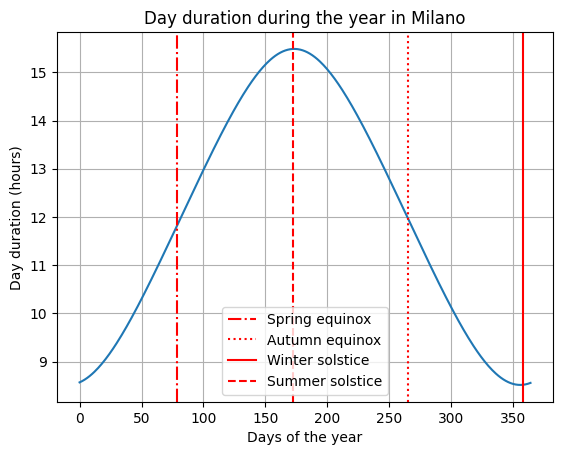

In [73]:
day_array=np.linspace(0,364, 365)
duration_array=np.zeros(len(day_array))

for i in range(len(duration_array)):
    duration_array[i]=day_duration(day_array[i], Lat)

plt.plot(day_array, duration_array)
plt.grid()
plt.xlabel("Days of the year")
plt.ylabel("Day duration (hours)")
plt.title("Day duration during the year in Milano")
plt.axvline(x=79, label="Spring equinox",linestyle="-.", color="red")
plt.axvline(x=265, label="Autumn equinox",linestyle=":", color="red")
plt.axvline(x=365-7, label="Winter solstice",linestyle="-",color="red")
plt.axvline(x=172, label="Summer solstice", linestyle="--", color="red")
plt.legend();



# Time arrays and values

In [74]:
longest_day= int(max(duration_array)*60)                        # minutes of longest day in Milan
shortest_day=24*60-longest_day                                  # minutes of shortest day in Milan

day=np.linspace(0,24*60, int(24*60)+1)                          # array containing each minute of the day
hours=[]                                                        # list of minutes but written as <<hours:minutes>>

for i in day:
    hours.append(str(int(i//60))+":"+str(int(i%60)).zfill(2))   # list day is filled

ticks=np.linspace(0,24,13)                                      # array of hours of the day
ticks_string=[]                                                 # list of moments to be displayed...
for i in ticks:                                                 # ...on the x-axis of a plot
    ticks_string.append(str(int(i))+":00")

# Functions for solar field modelling

In [75]:
#######################################################################################################
#Converts from data of the weather forecast to a clearness index
@njit
def clearness_index (weather_class: int):

    return (0.0014*weather_class**5)-(0.0108*weather_class**4) + (0.0128*weather_class**3) + (0.0252*weather_class**2) + (0.1836*weather_class)+0.3804


#######################################################################################################
#power output given plant power, irradiance of the day, Temperature of modules
@njit
def power_output(nominal_power, irradiance_ratio, module_temperature):

    return nominal_power*(irradiance_ratio)*(1+gamma*(module_temperature-25))*PLF*panel_to_field_efficiency


#######################################################################################################
@njit
def forecast(day_length=None, latitude=None): # forecast generator
    if day_length==None:
        day_length=random.randint(shortest_day, longest_day)#duration of the day in minutes

    if latitude==None:
        flag=random.randint(0,366)
        if flag<144:
            weather=random.uniform(1,4)
        elif flag < 144+95+77:
            weather=random.uniform(0,1)
        else:
            weather=random.uniform(-1,0)
        # weather=random.uniform(-1,4) # weather class generator
    else:
        #weather=4-random.uniform(0,5)*((latitude/45))**0.25
        flag=random.randint(0,366)
        if flag<144:
            weather=random.uniform(2.5,4)
        elif flag < 144+95+77:
            weather=random.uniform(0.5,2.5)
        else:
            weather=random.uniform(-1,0.5)
        # weather=random.uniform(-1,4) # weather class generator
    max_T=25+(day_length-12*60)/60*3 +random.uniform(-5,5) #max T of the day
    min_T=10+(day_length-12*60)/60*3 +random.uniform(-5,5) #min T of the day

    return [day_length, min_T,max_T, weather]


#######################################################################################################
#generates arrays of same length: time, temperature and irrradiatin
#takes length of day, T forecst and weather forecast
@njit
def profile_generator (day_length, min_T_forecast, max_T_forecast, weather_forecast):
    weather_forecast_local=weather_forecast
    #temperature array
    temperature_array=np.zeros(len(day))
    #irradiance array
    irradiance_ratio_array=np.zeros(len(day))
    #hour of maximum temperature
    max_hour=random.uniform(11,14)

    for i in range(len(day)):
        weather_changes=random.randint(0,4)
        if (weather_changes not in [0,1]) and i %(len(day)//weather_changes)==0:
            weather_forecast_local=weather_forecast_local+random.uniform(-0.5,0.5)
        temperature_array[i]= (max_T_forecast-min_T_forecast)*math.exp(-((day[i]-(max_hour*60))**2)/((day_length/4)**2))+min_T_forecast 
        
        if day[i]>(12*60- int(day_length/2)) and  day[i]<(12*60+ int(day_length/2)):#before dusk and after dawn irradiation is null
            
            irradiance_ratio_array[i] = (clearness_index(weather_forecast_local)*math.sin(math.pi/day_length*(day[i]-12*60)+math.pi/2))

    for k in range(50):
        for i in range(len(irradiance_ratio_array)):
            if day[i]>(12*60- int(day_length/2)) and  day[i]<(12*60+ int(day_length/2)):
                irradiance_ratio_array[i+1]=(irradiance_ratio_array[i]+irradiance_ratio_array[i+2])/2

    profile={"temperature": temperature_array, "time": day, "irradiation": irradiance_ratio_array}

    return profile


#######################################################################################################
# function that RANDOMLY generates a power, temperature, irradiance and time array
@njit
def random_power_profile_generator():

    forecast_parameters=forecast()
    forecast_profile=profile_generator(forecast_parameters[0], forecast_parameters[1], forecast_parameters[2], forecast_parameters[3])

    power_profile=np.zeros(len(forecast_profile["time"]))

    if random.uniform(0,1)<0.8:

        for i in range(len(power_profile)):
            if forecast_profile["irradiation"][i]>0 :
                power_profile[i]=power_output(plant_power,forecast_profile["irradiation"][i], forecast_profile["temperature"][i])

    return [power_profile, forecast_profile["irradiation"], forecast_profile["temperature"]]

#######################################################################################################
# function that generates a power, temperature, irradiance and time array given the forecast
@njit
def power_profile_generator(day_length, min_T_forecast, max_T_forecast, weather_forecast):

    forecast_parameters=[day_length, min_T_forecast, max_T_forecast, weather_forecast]
    forecast_profile=profile_generator(forecast_parameters[0], forecast_parameters[1], forecast_parameters[2], forecast_parameters[3])

    power_profile=np.zeros(len(forecast_profile["time"]))

    if random.uniform(0,1)<0.8:

        for i in range(len(power_profile)):
            if forecast_profile["irradiation"][i]>0:

                power_profile[i]=power_output(plant_power,forecast_profile["irradiation"][i], forecast_profile["temperature"][i])

    return [power_profile, forecast_profile["irradiation"], forecast_profile["temperature"]]

#######################################################################################################
# function to plot power profiles
def power_plotter(profile):
    
    plt.plot(hours, profile)
    plt.xticks(ticks_string, fontsize=8)
    plt.xlabel("Time")
    plt.ylabel("Power profile (kwh)")
    plt.grid()

#######################################################################################################
# function to reduce the length of profiles by averaging
def averaging(array, final_length):
    elements_to_be_averaged=len(array)//final_length

    averaged_array=np.zeros(final_length)

    for i in range(len(averaged_array)):
        if i==0:
            averaged_array[i]=array[0]
        else:
            averaged_array[i]=np.average(array[(i-1)*elements_to_be_averaged: i*elements_to_be_averaged])
    return averaged_array

#######################################################################################################
#day duration
def yearly_power_latitude_simulator(lat_value):
    global day_array
    year_power_profile=np.zeros(len(day_array))
    average_year_profile=np.zeros(len(day_array))
    std_error=np.zeros(len(day_array))

    profiles=[]

    for j in range(1000):
        for i in range(len(day_array)):
            generated_forecast=forecast(day_length=int(day_duration(day_array[i], lat_value)*60), latitude=lat_value)
            data=power_profile_generator(generated_forecast[0], generated_forecast[1], generated_forecast[2], generated_forecast[3])
            year_power_profile[i]=float(np.average(data[0])*24)

        average_year_profile+=year_power_profile

    average_year_profile=average_year_profile/1000
    return average_year_profile

# Power profiles

Randomly generated power profile

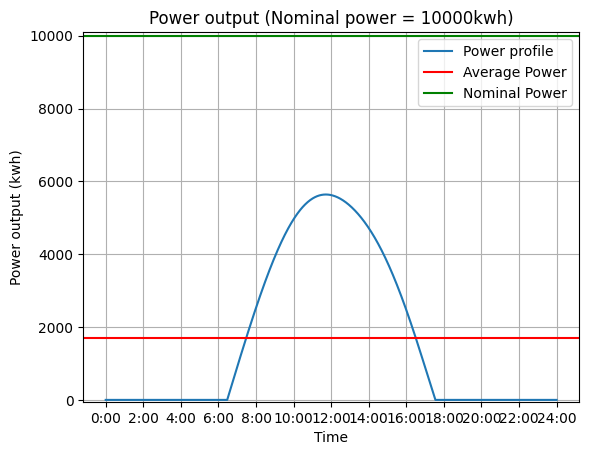

In [76]:
trial=random_power_profile_generator()
plt.plot(hours, trial[0], label="Power profile")
plt.xticks(ticks_string)
plt.grid()
plt.xlabel("Time")
plt.ylabel("Power output (kwh)")
plt.title("Power output (Nominal power = "+ str(plant_power)+ "kwh)")
plt.axhline(y=np.average(trial[0]), label="Average Power", color="red")
plt.axhline(y=plant_power, label="Nominal Power", color="green")
plt.ylim(-50,plant_power+100)
plt.legend()


Comparison between different profiles

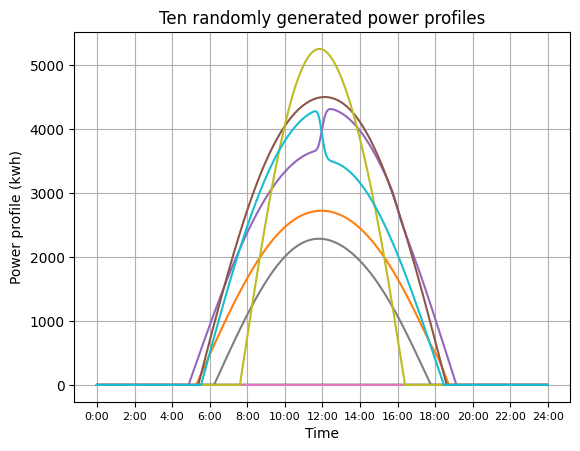

In [77]:
for j in range(10):

    trial=random_power_profile_generator()
    power_plotter(trial[0])

plt.grid()
plt.title("Ten randomly generated power profiles");

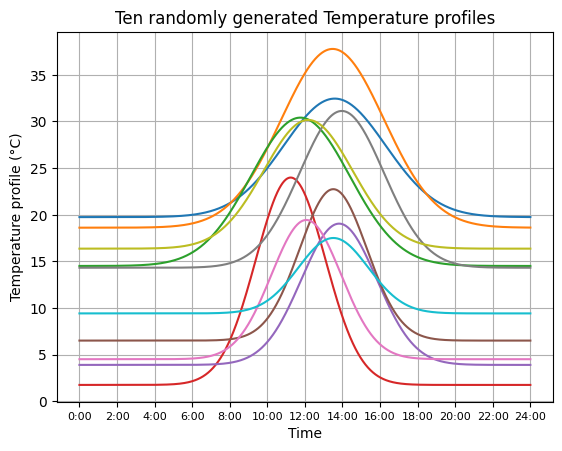

In [78]:
for j in range(10):

    trial=random_power_profile_generator()
    plt.plot(hours, trial[2])
    plt.xticks(ticks_string, fontsize=8)
    plt.xlabel("Time")
    plt.ylabel("Temperature profile (°C)")
    plt.grid()

plt.grid()
plt.title("Ten randomly generated Temperature profiles");


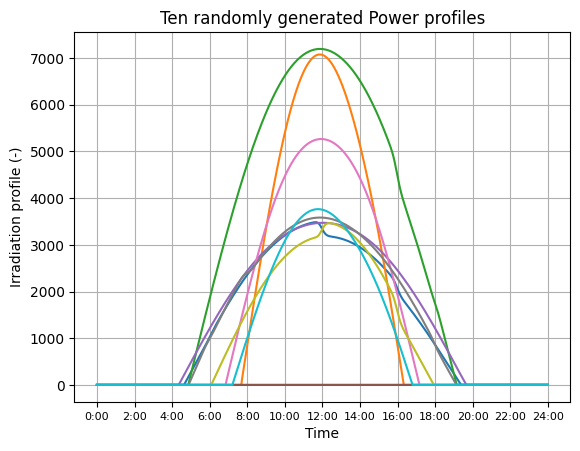

In [79]:
for j in range(10):

    trial=random_power_profile_generator()
    plt.plot(hours, trial[0])
    plt.xticks(ticks_string, fontsize=8)
    plt.xlabel("Time")
    plt.ylabel("Irradiation profile (-)")
    plt.grid()

plt.grid()
plt.title("Ten randomly generated Power profiles");

Statistical analysis

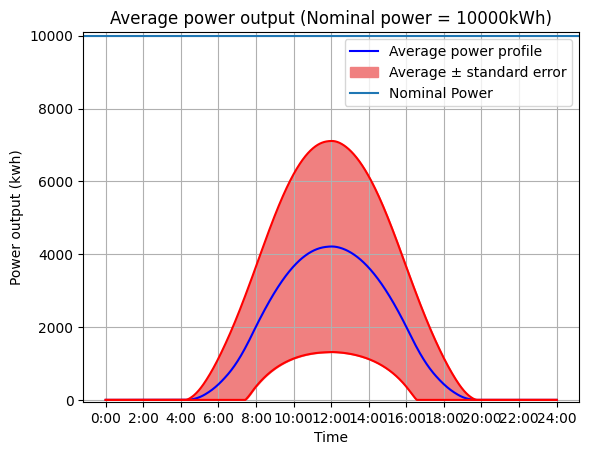

In [80]:
#dataset creation and filling
dataset=[]
simulations_number=1000
for j in range(simulations_number):

    trial=random_power_profile_generator()
    dataset.append(trial[0])

#average profile
average=np.zeros(len(day))
#variance
variance=np.zeros(len(day))
#std error
std_error=np.zeros(len(day))

for i in range(len(day)):
    #average
    for j in range(len(dataset)):
        average[i]=average[i]+dataset[j][i]
    average[i]=average[i]/len(dataset)

    #variance
    for j in range(len(dataset)):
        variance[i]=variance[i]+(average[i]-dataset[j][i])**2
    variance[i]=variance[i]/(len(dataset)-1)

    std_error[i]=variance[i]**0.5

upper_bound=average+std_error
lower_bound=average-std_error
for i in range(len(lower_bound)):
    if lower_bound[i]<0:
        lower_bound[i]=0

plt.plot(hours, average, label="Average power profile", color="blue")
plt.plot(hours, upper_bound, color="red")
plt.plot(hours, lower_bound,  color="red")
plt.xticks(ticks_string)
plt.fill_between(hours, average+std_error, average-std_error, color="lightcoral", label="Average \u00B1 standard error")
plt.fill_between(hours,-50*np.ones(len(hours)), color='white')
plt.grid()
plt.xlabel("Time")
plt.ylabel("Power output (kwh)")
plt.title("Average power output (Nominal power = "+ str(plant_power)+ "kWh)")
plt.axhline(y=plant_power, label="Nominal Power")
plt.ylim(-50,plant_power+100)
plt.legend()



histogram

The minimum power output is 0 kwh.

The maximum power output is 83293 kWh.

the average power output is 32652 kwh.
which corresponds to 1197 equivalent hours per year


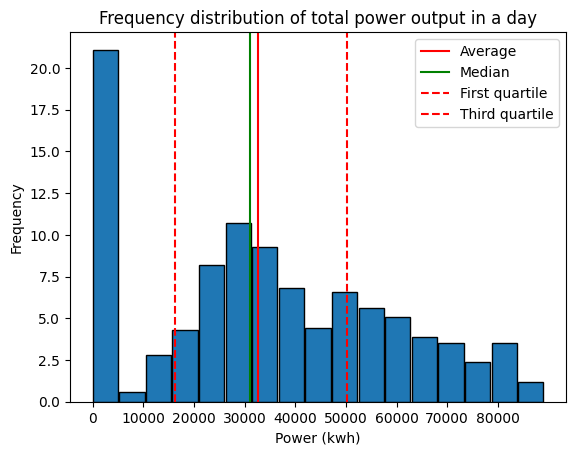

In [81]:
total_power_output=[]
for i in range(len(dataset)):
    total_power_output.append(round(float(np.average(dataset[i])*24)))

average_total_power=np.average(total_power_output)
median_total_output=np.median(total_power_output)
first_quartile=np.quantile(total_power_output, 0.25)
third_quartile=np.quantile(total_power_output, 0.75)

print("The minimum power output is "+ str(min(total_power_output))+" kwh.")
print('')
print("The maximum power output is "+ str(max(total_power_output))+" kWh.")
print('')
print("the average power output is "+ str(round(float(average_total_power)))+" kwh.")
print('which corresponds to '+ str(round(float(average_total_power)/plant_power/24*8800))+ " equivalent hours per year")
bars=np.linspace(0,((max(total_power_output)//1000)+1)*1000, (((max(total_power_output)//1000)+1)*1000)//(plant_power//2)+1)

bars_counter=np.zeros(len(bars))

for i in range(len(total_power_output)):
    level=total_power_output[i]//(plant_power//2)
    bars_counter[int(level)]+=1

hist_bars=[]
for k in range(max(total_power_output)//(plant_power)+1):
    hist_bars.append(int(plant_power)*k)

plt.bar(bars, bars_counter/simulations_number*100, width=plant_power//2, edgecolor="black", align="edge")
plt.title("Frequency distribution of total power output in a day")
plt.ylabel("Frequency");
plt.xlabel("Power (kwh)");
plt.xticks(hist_bars, fontsize="10");
plt.axvline(x=average_total_power, label="Average", color='red')
plt.axvline(x=median_total_output, label="Median", color ="green")
plt.axvline(x=first_quartile, label="First quartile", color="red", linestyle="--")
plt.axvline(x=third_quartile, label="Third quartile", color="red", linestyle="--")
plt.legend();


In [82]:
trial=yearly_power_latitude_simulator(45)

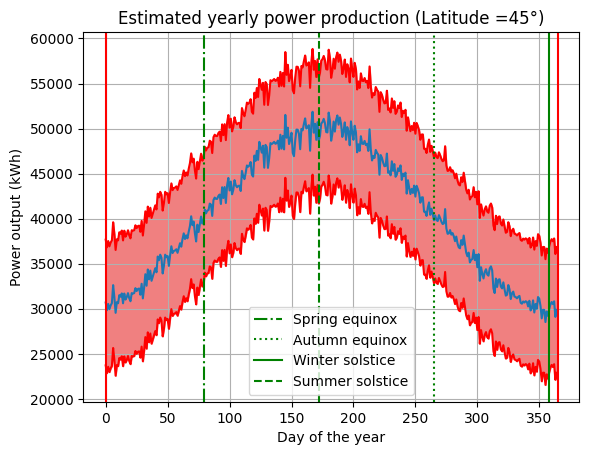

In [83]:
plt.plot(day_array, trial)
plt.plot(day_array, trial-np.std(trial), color="red")
plt.plot(day_array, trial+np.std(trial), color="red")
plt.grid()
plt.xlabel("Day of the year")
plt.ylabel("Power output (kWh)")
plt.title("Estimated yearly power production (Latitude =45°)")
plt.axvline(x=79, label="Spring equinox",linestyle="-.", color="green")
plt.axvline(x=265, label="Autumn equinox",linestyle=":", color="green")
plt.axvline(x=365-7, label="Winter solstice",linestyle="-",color="green")
plt.axvline(x=172, label="Summer solstice", linestyle="--", color="green")
plt.fill_between(day_array, trial+np.std(trial), trial-np.std(trial), color="lightcoral");
plt.axvline(x=0, color="red")
plt.axvline(x=365, color="red")
plt.legend();

In [84]:
print(int(np.average(trial)*365/1000)) #MWh
print(int(np.std(trial)*365)/1000) #MWh

print(int(np.average(trial))*365*24/plant_power/24)
print(int(np.std(trial))*365*24/plant_power/24)

14747
2546.936
1474.7095
254.66049999999998


In [85]:
# Load the data
database = pd.read_excel("PZ_nord_2024.xlsx")
database.columns = ['Data', 'Ora', 'price']

# Function to replace commas with periods in strings
def csv_to_dot(x):
    return x.replace(",", ".")

# Create an empty array to store the cleaned price data
price_database = np.zeros(len(database))

# Loop through each row and apply the csv_to_dot function
for i in range(len(database)):

    price_database[i] = float(csv_to_dot(str(database["price"].iloc[i])))


average_price=np.zeros(24)
std_price=np.zeros(24)

In [86]:
data_list=[]
for j in range(24):
    hourly_data=[]
    for i in range(len(price_database)):
        if i%24==j:
            hourly_data.append(price_database[i])
    
    data_list.append(hourly_data)

for i in range(len(average_price)):
    average_price[i]=np.average(np.array(data_list[i]))
    std_price[i]=np.std(np.array(data_list[i]))


In [87]:
weights=averaging(average, len(average_price))
our_price=0
for i in range(len(weights)):
    our_price=our_price+weights[i]*average_price[i]

our_price=our_price/np.sum(weights)

In [88]:
print(our_price)

102.77154596228682


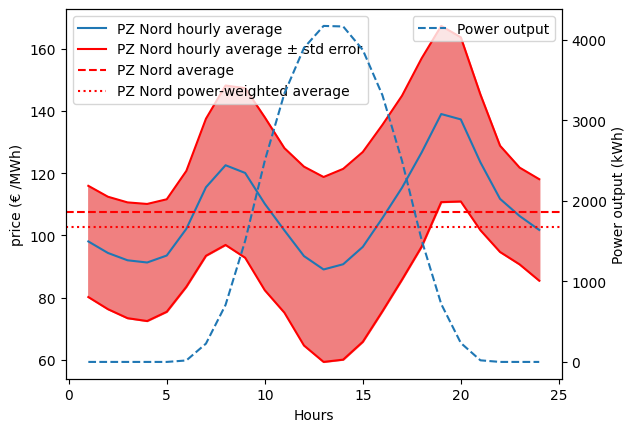

In [89]:
# Create the figure and the first axis
fig, ax1 = plt.subplots()

# Plot data for the first y-axis
ax1.plot(range(1,25), average_price, label= "PZ Nord hourly average")
ax1.plot(range(1,25), average_price-std_price, color="red", label= "PZ Nord hourly average \u00B1 std error")
ax1.plot(range(1,25), average_price+std_price, color="red")
ax1.set_xlabel("Hours")
ax1.set_ylabel("price (\u20AC /MWh)")
ax1.tick_params(axis='y')
ax1.axhline(np.average(average_price), label="PZ Nord average", color="red", linestyle="--")
ax1.axhline(np.average(our_price), label="PZ Nord power-weighted average", color="red", linestyle=":")
ax1.fill_between(range(1,25), average_price-std_price, average_price+std_price, color="lightcoral");
ax1.legend()

# Create the second y-axis using twinx()
ax2 = ax1.twinx()

# Plot data for the second y-axis
ax2.plot(range(1,25), weights, linestyle="--", label="Power output")
ax2.set_ylabel("Power output (kWh)")
ax2.tick_params(axis='y')
ax2.legend()

# Show the plot
plt.show()